In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.errors import InvalidArgumentError
import tensorflow as tf

# Tensorflow GPU settings
# gpu_options = tf.GPUOptions(allow_growth=True)#per_process_gpu_memory_fraction=0.5)
# sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import shuffle

from scipy import interpolate

from atlasify import atlasify
import pickle
import os

In [2]:
sig = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220117_iso_e4m1_VVZ_RD.arrow')
sig['is_signal'] = True
# sig = sig[sig.SR == 2]

bg = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220117_iso_e4m1_FULLBG_RD.arrow')
bg['is_signal'] = False
# bg = bg[bg.SR == 2]

In [3]:
train_feats_raw = sorted([f for f in sig.columns if f not in ['index', 'wgt', 'is_signal', 
                                                              'Zcand_mass', 'chisq']])

train_feat_sets = [train_feats_raw, 
                   [f for f in train_feats_raw if f not in ['Wlep1_phi', 'Wlep2_phi', 'Zlep1_phi', 'Zlep2_phi']],
                   [f for f in train_feats_raw if f not in ['MET', 'METSig']],
                   [f for f in train_feats_raw if f not in ['pt_1', 'pt_2', 'pt_3', 'pt_4']],
                   [f for f in train_feats_raw if f not in ['Njet', 'Nlep']]
                  ]

In [4]:
# Normalize training features
X = pd.concat([sig[train_feats_raw], bg[train_feats_raw]], ignore_index=True)

min_max_scaler = preprocessing.MinMaxScaler()

min_max_scaler.fit(X)

for df in [sig, bg]:
    df[train_feats_raw] = min_max_scaler.transform(df[train_feats_raw])

In [5]:
# Load per-background models
models_dir = 'models/background_id_models/'

background_classifiers = {'ZZ': 1, 'Zjets': 2, 'WZ': 1, 'ttZ': 0, 'other': 1}

for bc_name in background_classifiers:
    bc_index = background_classifiers[bc_name]
    
    classifier = keras.models.load_model((models_dir + 'classifier_' + bc_name 
                                          + '_train_feat_test_' + str(bc_index)))
    sig['classifier_' + bc_name + '_score'] = classifier.predict(sig[train_feat_sets[bc_index]], 
                                                                    batch_size=10000)
    bg['classifier_' + bc_name + '_score'] = classifier.predict(bg[train_feat_sets[bc_index]], 
                                                                   batch_size=10000)

2022-01-31 16:07:01.832322: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-31 16:07:01.835069: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 4000 computeCapability: 7.5
coreClock: 1.545GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 387.49GiB/s
2022-01-31 16:07:01.835143: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-01-31 16:07:01.835170: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-01-31 16:07:01.835185: I tensorflow/stream_executor/plat

In [6]:
# Cut to 4l-DF signal region
bg = bg[bg.SR == 0]
sig = sig[sig.SR == 0]

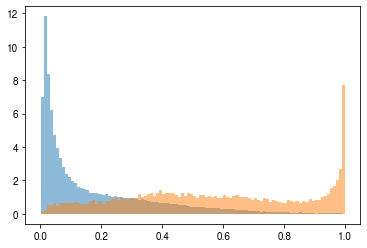

In [7]:
_, b, _ = plt.hist(bg.classifier_ZZ_score, bins=100, weights=bg.wgt, density=True, alpha=0.5)
plt.hist(sig.classifier_ZZ_score, bins=b, weights=sig.wgt, density=True, alpha=0.5)

plt.show()

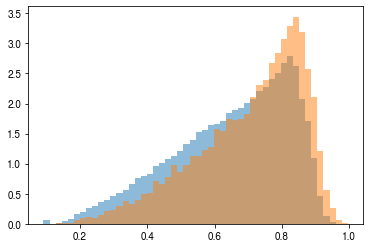

In [8]:
_, b, _ = plt.hist(bg.classifier_Zjets_score, bins=50, weights=bg.wgt, density=True, alpha=0.5)
plt.hist(sig.classifier_Zjets_score, bins=b, weights=sig.wgt, density=True, alpha=0.5)

plt.show()

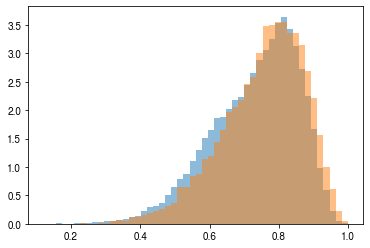

In [9]:
_, b, _ = plt.hist(bg.classifier_WZ_score, bins=50, weights=bg.wgt, density=True, alpha=0.5)
plt.hist(sig.classifier_WZ_score, bins=b, weights=sig.wgt, density=True, alpha=0.5)

plt.show()

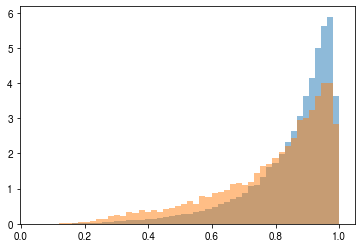

In [10]:
_, b, _ = plt.hist(bg.classifier_ttZ_score, bins=50, weights=bg.wgt, density=True, alpha=0.5)
plt.hist(sig.classifier_ttZ_score, bins=b, weights=sig.wgt, density=True, alpha=0.5)

plt.show()

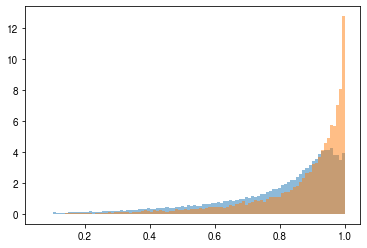

In [11]:
_, b, _ = plt.hist(bg.classifier_other_score, bins=100, weights=bg.wgt, density=True, alpha=0.5)
plt.hist(sig.classifier_other_score, bins=b, weights=sig.wgt, density=True, alpha=0.5)

plt.show()

# Train model

First we want to figure out the signal/background ratio

In [12]:
def region_sig(s, b):
    if s == 0:
        return 0
    return np.sqrt(2 * ((s + b) * np.log(1 + s / b) - s))

n_bg = sum(bg.wgt)
n_sig = sum(sig.wgt)

print('There are', n_bg, 'background events')
print('There are', n_sig, 'signal events')
print('')
print('S/B =', n_sig/n_bg)
print('Starting significance is', region_sig(n_sig, n_bg), 'sigma')
print('Corresponds to', np.sqrt(2.0) * region_sig(n_sig, n_bg), 'sigma')

There are 1156.3337963132874 background events
There are 5.726832988559573 signal events

S/B = 0.004952577713129464
Starting significance is 0.1682732254181331 sigma
Corresponds to 0.2379742775705889 sigma


In [13]:
bg['abs_wgt'] = np.abs(bg.wgt)
sig['abs_wgt'] = np.abs(sig.wgt)

/tmp/kbenkend/ipykernel_68339/2235700710.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bg['abs_wgt'] = np.abs(bg.wgt)


In [14]:
bg_classifier_score_feats = ['classifier_' + bc + '_score' for bc in background_classifiers]
combined_train_feats_raw = train_feats_raw + bg_classifier_score_feats

combined_train_feat_sets = [combined_train_feats_raw, 
                            [f for f in combined_train_feats_raw if f not in bg_classifier_score_feats],
                            [f for f in combined_train_feats_raw if f not in ['Wlep1_phi', 'Wlep2_phi', 
                                                                              'Zlep1_phi', 'Zlep2_phi']],
                            [f for f in combined_train_feats_raw if f not in ['MET', 'METSig']],
                            [f for f in combined_train_feats_raw if f not in ['pt_1', 'pt_2', 'pt_3', 'pt_4']],
                            [f for f in combined_train_feats_raw if f not in ['Njet', 'Nlep']]
                           ]

In [ ]:
EPOCHS = 10000
patience = 500
batch_size = 512
num_nodes = 64
dropout = 0.1
learn_rate = 1e-5

for i, train_feats in enumerate(combined_train_feat_sets):
    model_dir = 'models/SR_4l_SF_inZ_models/'
    model_name = 'classifier_train_feat_test_' + str(i)
    
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    
    print('Running with training features:', train_feats)
    # Save training setup
    with open(model_dir + model_name + '_setup.txt', 'w') as file:
        file.write('Epochs: ' + str(EPOCHS) + '\n')
        file.write('Patience: ' + str(patience) + '\n')
        file.write('Learning rate: ' + str(learn_rate) + '\n')
        file.write('Batch size: ' + str(batch_size) + '\n\n')
        file.write('Training features:\n' + '\n'.join(train_feats))
    
    # Generate train and test samples
    sig_train, sig_test = train_test_split(sig[train_feats + ['wgt']], train_size=0.5, random_state=314)
    bg_train, bg_test = train_test_split(bg[train_feats + ['wgt']], train_size=0.5, random_state=314)

    n_sig = sum(sig_train.wgt)
    n_bg = sum(bg_train.wgt)

    x_train_sig = sig_train[train_feats]
    x_train_bg = bg_train[train_feats]

    x_train = pd.concat([x_train_sig, x_train_bg])
    y_train = np.concatenate([np.ones(len(sig_train)), np.zeros(len(bg_train))])
    w_train = pd.Series(np.concatenate([(n_sig + n_bg) / n_sig * sig_train['wgt'], 
                                        (n_sig + n_bg) / n_bg * bg_train['wgt']]))

    n_sig_test = sum(sig_test.wgt)
    n_bg_test = sum(bg_test.wgt)

    x_test = pd.concat([sig_test[train_feats], bg_test[train_feats]])
    y_test = np.concatenate([np.ones(len(sig_test)), np.zeros(len(bg_test))])
    w_test = pd.Series(np.concatenate([(n_sig_test + n_bg_test) / n_sig_test * sig_test['wgt'], 
                                       (n_sig_test + n_bg_test) / n_bg_test * bg_test['wgt']]))
    
    # Generate and fit model
    K.clear_session()
    classifier = Sequential()
    classifier.add(Dense(num_nodes, input_dim=x_train.shape[1], activation='relu')) 
    classifier.add(Dropout(dropout))
    classifier.add(Dense(num_nodes, activation='relu'))
    classifier.add(Dropout(dropout))
    classifier.add(Dense(num_nodes, activation='relu'))
    classifier.add(Dropout(dropout))
    classifier.add(Dense(1, activation='sigmoid'))

    opt = keras.optimizers.Adam(learning_rate=learn_rate)
    classifier.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    # Early stopping
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    history = classifier.fit(x_train, y_train, epochs=EPOCHS, batch_size=batch_size,
                             validation_data=(x_test, y_test, w_test), sample_weight=w_train, 
                             verbose=1, callbacks=[callback], shuffle=True)
    
    # Save model and history
    classifier.save(model_dir + model_name)
    with open(model_dir + model_name + '_history.pkl', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

Running with training features: ['HT', 'MET', 'METSig', 'Njet', 'Nlep', 'SR', 'Wlep1_dphi', 'Wlep1_eta', 'Wlep1_phi', 'Wlep1_pid', 'Wlep1_pt', 'Wlep2_dphi', 'Wlep2_eta', 'Wlep2_phi', 'Wlep2_pid', 'Wlep2_pt', 'Zlep1_dphi', 'Zlep1_eta', 'Zlep1_phi', 'Zlep1_pid', 'Zlep1_pt', 'Zlep2_dphi', 'Zlep2_eta', 'Zlep2_phi', 'Zlep2_pid', 'Zlep2_pt', 'leptonic_HT', 'mass_4l', 'other_mass', 'pt_1', 'pt_2', 'pt_3', 'pt_4', 'pt_4l', 'total_HT', 'classifier_ZZ_score', 'classifier_Zjets_score', 'classifier_WZ_score', 'classifier_ttZ_score', 'classifier_other_score']
Epoch 1/10000
870/870 [==============================] - 5s 6ms/step - loss: 0.0018 - accuracy: 0.4231 - val_loss: 0.0018 - val_accuracy: 0.3696
Epoch 2/10000
870/870 [==============================] - 5s 6ms/step - loss: 0.0018 - accuracy: 0.5492 - val_loss: 0.0017 - val_accuracy: 0.5969
Epoch 3/10000
870/870 [==============================] - 5s 6ms/step - loss: 0.0017 - accuracy: 0.6109 - val_loss: 0.0017 - val_accuracy: 0.6702
Epoch 4/1000

870/870 [==============================] - 5s 6ms/step - loss: 0.0012 - accuracy: 0.6538 - val_loss: 0.0012 - val_accuracy: 0.6402
Epoch 54/10000
870/870 [==============================] - 5s 5ms/step - loss: 0.0012 - accuracy: 0.6483 - val_loss: 0.0012 - val_accuracy: 0.6457
Epoch 55/10000
870/870 [==============================] - 5s 6ms/step - loss: 0.0012 - accuracy: 0.6496 - val_loss: 0.0012 - val_accuracy: 0.6515
Epoch 56/10000
870/870 [==============================] - 5s 5ms/step - loss: 0.0012 - accuracy: 0.6568 - val_loss: 0.0012 - val_accuracy: 0.6381
Epoch 57/10000
870/870 [==============================] - 5s 5ms/step - loss: 0.0012 - accuracy: 0.6435 - val_loss: 0.0012 - val_accuracy: 0.6425
Epoch 58/10000
870/870 [==============================] - 5s 6ms/step - loss: 0.0012 - accuracy: 0.6492 - val_loss: 0.0012 - val_accuracy: 0.6405
Epoch 59/10000
870/870 [==============================] - 5s 6ms/step - loss: 0.0012 - accuracy: 0.6503 - val_loss: 0.0012 - val_accuracy: 

870/870 [==============================] - 5s 5ms/step - loss: 0.0012 - accuracy: 0.6368 - val_loss: 0.0012 - val_accuracy: 0.6359
Epoch 110/10000
870/870 [==============================] - 5s 6ms/step - loss: 0.0012 - accuracy: 0.6351 - val_loss: 0.0012 - val_accuracy: 0.6318
Epoch 111/10000
870/870 [==============================] - 5s 6ms/step - loss: 0.0012 - accuracy: 0.6346 - val_loss: 0.0012 - val_accuracy: 0.6336
Epoch 112/10000
870/870 [==============================] - 5s 6ms/step - loss: 0.0012 - accuracy: 0.6362 - val_loss: 0.0012 - val_accuracy: 0.6316
Epoch 113/10000
870/870 [==============================] - 5s 6ms/step - loss: 0.0012 - accuracy: 0.6340 - val_loss: 0.0012 - val_accuracy: 0.6357
Epoch 114/10000
870/870 [==============================] - 5s 5ms/step - loss: 0.0012 - accuracy: 0.6393 - val_loss: 0.0012 - val_accuracy: 0.6280
Epoch 115/10000
870/870 [==============================] - 5s 6ms/step - loss: 0.0012 - accuracy: 0.6332 - val_loss: 0.0012 - val_accu

Epoch 165/10000
870/870 [==============================] - 5s 5ms/step - loss: 0.0012 - accuracy: 0.6279 - val_loss: 0.0012 - val_accuracy: 0.6213
Epoch 166/10000
870/870 [==============================] - 5s 6ms/step - loss: 0.0012 - accuracy: 0.6291 - val_loss: 0.0012 - val_accuracy: 0.6187
Epoch 167/10000
870/870 [==============================] - 5s 5ms/step - loss: 0.0012 - accuracy: 0.6252 - val_loss: 0.0012 - val_accuracy: 0.6274
Epoch 168/10000
870/870 [==============================] - 5s 6ms/step - loss: 0.0012 - accuracy: 0.6276 - val_loss: 0.0012 - val_accuracy: 0.6242
Epoch 169/10000
870/870 [==============================] - 5s 6ms/step - loss: 0.0012 - accuracy: 0.6293 - val_loss: 0.0012 - val_accuracy: 0.6172
Epoch 170/10000
870/870 [==============================] - 5s 5ms/step - loss: 0.0012 - accuracy: 0.6235 - val_loss: 0.0012 - val_accuracy: 0.6215
Epoch 171/10000
870/870 [==============================] - 5s 6ms/step - loss: 0.0011 - accuracy: 0.6274 - val_loss: 0

Epoch 221/10000
870/870 [==============================] - 5s 6ms/step - loss: 0.0012 - accuracy: 0.6217 - val_loss: 0.0012 - val_accuracy: 0.6164
Epoch 222/10000
870/870 [==============================] - 5s 5ms/step - loss: 0.0012 - accuracy: 0.6173 - val_loss: 0.0012 - val_accuracy: 0.6203
Epoch 223/10000
870/870 [==============================] - 5s 6ms/step - loss: 0.0012 - accuracy: 0.6200 - val_loss: 0.0012 - val_accuracy: 0.6189
Epoch 224/10000
870/870 [==============================] - 5s 5ms/step - loss: 0.0012 - accuracy: 0.6199 - val_loss: 0.0012 - val_accuracy: 0.6156
Epoch 225/10000
870/870 [==============================] - 5s 5ms/step - loss: 0.0011 - accuracy: 0.6212 - val_loss: 0.0012 - val_accuracy: 0.6134
Epoch 226/10000
870/870 [==============================] - 5s 5ms/step - loss: 0.0012 - accuracy: 0.6176 - val_loss: 0.0011 - val_accuracy: 0.6120
Epoch 227/10000
870/870 [==============================] - 5s 6ms/step - loss: 0.0012 - accuracy: 0.6167 - val_loss: 0

Epoch 278/10000
870/870 [==============================] - 5s 6ms/step - loss: 0.0012 - accuracy: 0.6173 - val_loss: 0.0011 - val_accuracy: 0.6101
Epoch 279/10000
870/870 [==============================] - 5s 5ms/step - loss: 0.0012 - accuracy: 0.6160 - val_loss: 0.0011 - val_accuracy: 0.6122
Epoch 280/10000
870/870 [==============================] - 5s 6ms/step - loss: 0.0012 - accuracy: 0.6156 - val_loss: 0.0011 - val_accuracy: 0.6096
Epoch 281/10000
870/870 [==============================] - 5s 6ms/step - loss: 0.0012 - accuracy: 0.6149 - val_loss: 0.0011 - val_accuracy: 0.6116
Epoch 282/10000
870/870 [==============================] - 5s 6ms/step - loss: 0.0012 - accuracy: 0.6131 - val_loss: 0.0011 - val_accuracy: 0.6126
Epoch 283/10000
870/870 [==============================] - 5s 6ms/step - loss: 0.0012 - accuracy: 0.6147 - val_loss: 0.0011 - val_accuracy: 0.6132
Epoch 284/10000
870/870 [==============================] - 5s 6ms/step - loss: 0.0011 - accuracy: 0.6166 - val_loss: 0

In [41]:
# Split train and test data
sig_train, sig_test = train_test_split(sig[combined_train_feats + ['wgt', 'abs_wgt']], train_size=0.5)
bg_train, bg_test = train_test_split(bg[combined_train_feats + ['wgt', 'abs_wgt']], train_size=0.5)

n_sig = sum(sig_train.wgt)
n_bg = sum(bg_train.wgt)

x_train_sig = pd.concat([sig_train[combined_train_feats]])
x_train_bg = bg_train[combined_train_feats]

x_train = pd.concat([x_train_sig, x_train_bg])
y_train = np.concatenate([np.ones(len(sig_train))] + [np.zeros(len(bg_train))])
w_train = pd.Series(np.concatenate([(n_sig + n_bg) / n_sig * sig_train['abs_wgt'], 
                                    (n_sig + n_bg) / n_bg * bg_train['abs_wgt']]))
# w_train = pd.Series(np.concatenate([sig_train['wgt']]*n_sig_copies + [bg_train['wgt']]))

n_sig_test = sum(sig_test.wgt)
n_bg_test = sum(bg_test.wgt)

x_test = pd.concat([sig_test[combined_train_feats], bg_test[combined_train_feats]])
y_test = np.concatenate([np.ones(len(sig_test)), np.zeros(len(bg_test))])
w_test = pd.Series(np.concatenate([(n_sig_test + n_bg_test) / n_sig_test * sig_test['abs_wgt'], 
                                   (n_sig_test + n_bg_test) / n_bg_test * bg_test['abs_wgt']]))

In [ ]:
# Fit ML classifier
EPOCHS = 10000
batch_size = 512
num_nodes = 64
dropout = 0.1

n_models = 10

plot_name = 'all_train_feats_updated_full_list_no_phi_10_models'

for i in range(n_models):
    # Generate and fit model
    classifier_4l_DF = Sequential()
    classifier_4l_DF.add(Dense(num_nodes, input_dim=x_train.shape[1], activation='relu')) 
    classifier_4l_DF.add(Dropout(dropout))
    classifier_4l_DF.add(Dense(num_nodes, activation='relu'))
    classifier_4l_DF.add(Dropout(dropout))
    classifier_4l_DF.add(Dense(num_nodes, activation='relu'))
    classifier_4l_DF.add(Dropout(dropout))
    classifier_4l_DF.add(Dense(1, activation='sigmoid'))

    opt = keras.optimizers.Adam(learning_rate=1e-5)
    classifier_4l_DF.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    # Early stopping
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1000, restore_best_weights=True)

    history = classifier_4l_DF.fit(x_train, y_train, epochs=EPOCHS, batch_size=batch_size,
                                   validation_data=(x_test, y_test, w_test), sample_weight=w_train, 
                                   verbose=1, callbacks=[callback], shuffle=True)
    
    bg_test['NN_out_' + str(i)] = classifier_4l_DF.predict(bg_test[combined_train_feats], batch_size=10000)
    sig_test['NN_out_' + str(i)] = classifier_4l_DF.predict(sig_test[combined_train_feats], batch_size=10000)

Epoch 1/10000
233/233 [==============================] - 2s 6ms/step - loss: 0.0027 - accuracy: 0.3298 - val_loss: 0.0027 - val_accuracy: 0.7700
Epoch 2/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0026 - accuracy: 0.6858 - val_loss: 0.0027 - val_accuracy: 0.9414
Epoch 3/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0025 - accuracy: 0.8669 - val_loss: 0.0026 - val_accuracy: 0.9457
Epoch 4/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0025 - accuracy: 0.9161 - val_loss: 0.0026 - val_accuracy: 0.9458
Epoch 5/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0025 - accuracy: 0.9312 - val_loss: 0.0026 - val_accuracy: 0.9459
Epoch 6/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0025 - accuracy: 0.9356 - val_loss: 0.0026 - val_accuracy: 0.9458
Epoch 7/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0024 - accuracy: 0.9379 - val_loss: 0.0025 - val_ac

233/233 [==============================] - 1s 6ms/step - loss: 0.0018 - accuracy: 0.7082 - val_loss: 0.0018 - val_accuracy: 0.6976
Epoch 114/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0018 - accuracy: 0.7090 - val_loss: 0.0018 - val_accuracy: 0.7031
Epoch 115/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0018 - accuracy: 0.7148 - val_loss: 0.0018 - val_accuracy: 0.7023
Epoch 116/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0018 - accuracy: 0.7102 - val_loss: 0.0018 - val_accuracy: 0.7008
Epoch 117/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0018 - accuracy: 0.7134 - val_loss: 0.0018 - val_accuracy: 0.7006
Epoch 118/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0017 - accuracy: 0.7135 - val_loss: 0.0018 - val_accuracy: 0.7014
Epoch 119/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0017 - accuracy: 0.7127 - val_loss: 0.0018 - val_accu

Epoch 169/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0018 - accuracy: 0.7226 - val_loss: 0.0018 - val_accuracy: 0.7251
Epoch 170/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0017 - accuracy: 0.7254 - val_loss: 0.0018 - val_accuracy: 0.7234
Epoch 171/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0018 - accuracy: 0.7279 - val_loss: 0.0018 - val_accuracy: 0.7238
Epoch 172/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0018 - accuracy: 0.7221 - val_loss: 0.0018 - val_accuracy: 0.7311
Epoch 173/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0017 - accuracy: 0.7301 - val_loss: 0.0018 - val_accuracy: 0.7251
Epoch 174/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0017 - accuracy: 0.7257 - val_loss: 0.0018 - val_accuracy: 0.7298
Epoch 175/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0018 - accuracy: 0.7268 - val_loss: 0

Epoch 225/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0017 - accuracy: 0.7455 - val_loss: 0.0017 - val_accuracy: 0.7447
Epoch 226/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0017 - accuracy: 0.7444 - val_loss: 0.0017 - val_accuracy: 0.7451
Epoch 227/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0017 - accuracy: 0.7444 - val_loss: 0.0017 - val_accuracy: 0.7475
Epoch 228/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0017 - accuracy: 0.7435 - val_loss: 0.0017 - val_accuracy: 0.7539
Epoch 229/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0017 - accuracy: 0.7474 - val_loss: 0.0017 - val_accuracy: 0.7503
Epoch 230/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0017 - accuracy: 0.7427 - val_loss: 0.0017 - val_accuracy: 0.7545
Epoch 231/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0016 - accuracy: 0.7511 - val_loss: 0

Epoch 281/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0017 - accuracy: 0.7616 - val_loss: 0.0017 - val_accuracy: 0.7692
Epoch 282/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0016 - accuracy: 0.7643 - val_loss: 0.0017 - val_accuracy: 0.7696
Epoch 283/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0017 - accuracy: 0.7612 - val_loss: 0.0017 - val_accuracy: 0.7757
Epoch 284/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0017 - accuracy: 0.7629 - val_loss: 0.0017 - val_accuracy: 0.7749
Epoch 285/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0016 - accuracy: 0.7721 - val_loss: 0.0017 - val_accuracy: 0.7745
Epoch 286/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0017 - accuracy: 0.7662 - val_loss: 0.0017 - val_accuracy: 0.7720
Epoch 287/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0016 - accuracy: 0.7660 - val_loss: 0

Epoch 337/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0016 - accuracy: 0.7788 - val_loss: 0.0017 - val_accuracy: 0.7916
Epoch 338/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0016 - accuracy: 0.7815 - val_loss: 0.0017 - val_accuracy: 0.7864
Epoch 339/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0016 - accuracy: 0.7738 - val_loss: 0.0017 - val_accuracy: 0.7906
Epoch 340/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0016 - accuracy: 0.7795 - val_loss: 0.0017 - val_accuracy: 0.7866
Epoch 341/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0016 - accuracy: 0.7705 - val_loss: 0.0017 - val_accuracy: 0.7930
Epoch 342/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0016 - accuracy: 0.7792 - val_loss: 0.0017 - val_accuracy: 0.7900
Epoch 343/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0016 - accuracy: 0.7808 - val_loss: 0

Epoch 393/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0016 - accuracy: 0.7854 - val_loss: 0.0016 - val_accuracy: 0.8050
Epoch 394/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0016 - accuracy: 0.7940 - val_loss: 0.0016 - val_accuracy: 0.8008
Epoch 395/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0016 - accuracy: 0.7845 - val_loss: 0.0016 - val_accuracy: 0.8047
Epoch 396/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0016 - accuracy: 0.7908 - val_loss: 0.0016 - val_accuracy: 0.8056
Epoch 397/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0016 - accuracy: 0.7871 - val_loss: 0.0017 - val_accuracy: 0.8123
Epoch 398/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0016 - accuracy: 0.7961 - val_loss: 0.0016 - val_accuracy: 0.8005
Epoch 399/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0016 - accuracy: 0.7863 - val_loss: 0

Epoch 449/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0016 - accuracy: 0.7989 - val_loss: 0.0016 - val_accuracy: 0.8123
Epoch 450/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0015 - accuracy: 0.8012 - val_loss: 0.0016 - val_accuracy: 0.8131
Epoch 451/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0016 - accuracy: 0.7961 - val_loss: 0.0016 - val_accuracy: 0.8200
Epoch 452/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0016 - accuracy: 0.7966 - val_loss: 0.0016 - val_accuracy: 0.8189
Epoch 453/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0016 - accuracy: 0.8028 - val_loss: 0.0016 - val_accuracy: 0.8131
Epoch 454/10000
233/233 [==============================] - 1s 6ms/step - loss: 0.0016 - accuracy: 0.7995 - val_loss: 0.0016 - val_accuracy: 0.8121
Epoch 455/10000
230/233 [============================>.] - ETA: 0s - loss: 0.0016 - accuracy: 0.7986

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [ ]:
nn_out_cols = ['NN_out_' + str(i) for i in range(n_models)]

bg_test['NN_out_mean'] = np.mean(bg_test[nn_out_cols], axis=1)
sig_test['NN_out_mean'] = np.mean(sig_test[nn_out_cols], axis=1)

In [ ]:
_, b, _ = plt.hist(bg_test.NN_out_mean, bins=20, alpha=0.7, weights=bg_test.wgt, label='Background')
plt.hist(sig_test.NN_out_mean, bins=b, alpha=0.7, weights=sig_test.wgt, label='Signal')

plt.ylabel('Events', fontsize=14)
plt.xlabel('NN output', fontsize=14)
plt.title('4$\ell$-DF', loc='right', fontsize=14)
plt.legend(fontsize=12)

plt.yscale('log')

atlasify('Internal Simulation', outside=True)
plt.minorticks_on()

plt.savefig('plots/SR_4l_DF_optimization/' + plot_name + '_events.png')
plt.savefig('plots/SR_4l_DF_optimization/' + plot_name + '_events.pdf')

In [ ]:
n_sig_pts = 100

nn_cuts = np.arange(0.0, 1.0, 1.0/n_sig_pts)
significances = [float('nan')]*n_sig_pts

max_sig_loc = 0
max_sig = 0

for i, nn_cut in enumerate(nn_cuts):
    n_bg = sum(bg_test[bg_test.NN_out_mean > nn_cut].wgt)
    n_sig = sum(sig_test[sig_test.NN_out_mean > nn_cut].wgt)
    
    try:
        current_sig = region_sig(n_sig, n_bg)
    except ZeroDivisionError:
        current_sig = float('nan')
    significances[i] = current_sig
    
    if current_sig > max_sig:
        max_sig = current_sig
        max_sig_loc = nn_cut
        
print('Max observed significance:', max_sig, 'sigma at cut of', max_sig_loc)
print('Corresponds to', 2*max_sig, 'sigma with full dataset')

In [ ]:
plt.plot(nn_cuts, significances)

plt.axhline(y=max_sig, color='black', ls='--')
plt.axvline(x=max_sig_loc, color='black', ls='--')

plt.ylabel('Significance', fontsize=14)
plt.xlabel('NN cut', fontsize=14)
plt.title('4$\ell$-DF', loc='right', fontsize=14)

plt.text(min(nn_cuts), min(significances), 
         'Max: %.2f $\sigma$\nCorresponds to %.2f $\sigma$\nLoc: %.2f'%(max_sig, 2*max_sig, max_sig_loc),
         fontsize=14)

atlasify('Internal Simulation', outside=True)

plt.savefig('plots/SR_4l_DF_optimization/' + plot_name + '.png')
plt.savefig('plots/SR_4l_DF_optimization/' + plot_name + '.pdf')